In [ ]:
import argparse
import time
import os
os.chdir(os.path.abspath(os.path.join('./alo')))
from src.alo import ALO
alo = ALO(); alo.preset(); pipelines = list(alo.asset_source.keys())
from src.external import external_load_data, external_save_artifacts

# alo train workflow 초기 세팅 
external_load_data(pipelines[0], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[0]
alo.install_steps(pipeline, alo.control["get_asset_source"])
# input asset 실행
step = 0 
input_args = alo.user_parameters[pipeline][step]['args'][0].copy()
data_input, config_input = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, {}, {}, [input_args])

#### Data
- boltfastening dataset
- 경로: /nas001/users/sujin2.lee/share/techtalk_sampling_1030/train/
- x_columns: 13개 (Count,Converted, Torque,angle_min,angle_mean,angle_median,angle_std,angle_max,torque_min,torque_mean,torque_median,torque_std,torque_max)
- y_column: label
- 총 데이터 수: 10100
- 라벨 별 데이터 수: 

In [2]:
data_input['dataframe']['label'].value_counts()

OK    10000
NG      100
Name: label, dtype: int64

<br>

### Sampling asset 사용법
- sampling asset은 data imbalance를 해결하기 위한 under sampling과 over sampling(TBD) 방법론을 제공합니다.
- sampling asset은 아래와 같은 방식으로 진행됩니다. 
    1. 데이터를 grouping하여 데이터 subgroup을 생성합니다.
        - 데이터의 라벨과 입력한 그룹키 컬럼을 기준으로 데이터를 subgroup으로 나눕니다.
        - 아래는 라벨과 그룹키 컬럼 모두 사용하여 subgroup을 나눈 case입니다.  

<div style='text-align:center'><img src="techtalk_sampling.PNG" width="500" height="500"/></div>
        
    2. 각 데이터 subgroup에 sampling 방법론을 적용합니다.

- sampling asset의 arguments 구성은 아래와 같습니다. 
    1. sampling 방법론 입력
    2. subgrouping할 경우 라벨 또는 그룹키 컬럼 입력
    3. sampling할 데이터 수 뽑는 방법 지정
|sampling 수 뽑는 방법|설명|값 예시|
|:---:|:---:|:---:|
|ratio|입력한 비율로 데이터 샘플링|0.8 (0초과 1이하)|
|number|입력한 숫자로 데이터 샘플링|500 (0초과)|
|mingroup|subgroup있을 때) 가장 크기가 작은 subgroup 기준으로 샘플링|-|
|compare|label기준 subgroup있을 때) 그룹 별 데이터를 입력한 값으로 비례하게 샘플링| {NG:1, OK:10} |

<br>

### Exercise
#### 1. 데이터 전체에 sampling 적용하기
- 데이터 subgroup 생성 없이 전체 데이터에 대해 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|ratio|ratio,number,mingroup|
|sampling_num|sampling_num_type의 인자를 입력합니다|0.8|위 sampling 데이터 수 지정 참고|  
- 아래는 전체 데이터에 대해 random sampling을 적용하는 예제입니다.
- sampling_args['argument 명'] = '값'을 입력하여 sampling asset의 arguments를 입력합니다.

In [3]:
step = 1
sampling_args = alo.user_parameters[pipeline][step]['args'][0].copy()
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'random'
sampling_args['sampling_num_type'] = 'ratio'
sampling_args['sampling_num'] = 0.8

In [4]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'random',
 'label_sampling': False,
 'ignore_label_class': None,
 'negative_target_class': None,
 'label_sampling_num_type': None,
 'label_sampling_num': None,
 'sampling_groupkey_columns': None,
 'sampling_num_type': 'ratio',
 'sampling_num': 0.8}

- sampling asset을 구동합니다

In [5]:
data_sampling, config_sampling = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_input, config_input.copy(), [sampling_args])

/home/jovyan/conda/envs/tcr1030/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/project2023/TCR/231030/tcr/alo//.train_artifacts/models/sampling/
load configs 0.00143 sec
make groupkey dataframe 0.00105 sec
groupkey:('all',), 8080개 sampling 시작
sampling process done 0.00357 sec
sampling asset 종료


/home/jovyan/project2023/TCR/231030/tcr/alo/assets/sampling/asset_sampling.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


#### input data와 sampling 한 후 data shape 비교

In [6]:
data_input['dataframe'].shape

(10100, 36)

In [7]:
data_sampling['dataframe'].shape

(8080, 37)

<br>

#### 2. 라벨 기준으로 데이터 subgroup 나누어 sampling 적용하기
- 라벨 기준으로 subgroup을 생성하여 각 라벨 데이터에 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|label_sampling|label sampling 진행 여부를 선택합니다.|False(기능 사용x)|True, False|
|ignore_label_class|특정 클래스에 대해 샘플링하지 않을 경우 지정합니다.|-|클래스 명 입력|  
|label_sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|label_sampling_num|label_sampling_num_type의 인자를 입력합니다.|-|위 sampling 수 지정 참고|
- 아래는 NG라벨은 샘플링 하지 않고, OK라벨 데이터를 NG라벨의 10배 cluster sampling하는 예제입니다. 
- sampling_args['argument 명'] = '값'을 입력하여 sampling asset의 arguments를 입력합니다.

In [8]:
step = 1
sampling_args = alo.user_parameters[pipeline][step]['args'][0].copy()
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'cluster'
sampling_args['label_sampling'] = True
sampling_args['ignore_label_class'] = 'NG'
sampling_args['label_sampling_num_type'] = 'compare'
sampling_args['label_sampling_num'] = {'NG':1,'OK':10}

In [9]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'cluster',
 'label_sampling': True,
 'ignore_label_class': 'NG',
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {'NG': 1, 'OK': 10},
 'sampling_groupkey_columns': None,
 'sampling_num_type': 'ratio',
 'sampling_num': 0.8}

- sampling asset을 구동합니다

************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/project2023/TCR/231030/tcr/alo//.train_artifacts/models/sampling/
load configs 0.00105 sec
make groupkey dataframe 0.00819 sec
standardization & embedding 28.88688 sec
groupkey:('OK',), 1000개 sampling 시작
cluster sampling start
cluster0 - eps:0.5, ms:2
0.06624 sec
cluster1 - eps:0.7, ms:2
0.07210 sec
cluster2 - eps:1, ms:2
0.08425 sec
cluster3 - eps:1.2, ms:2
0.09193 sec
cluster4 - eps:0.5, ms:3
0.06257 sec
cluster5 - eps:0.7, ms:3
0.07084 sec
cluster6 - eps:1, ms:3
0.08261 sec
cluster7 - eps:1.2, ms:3
0.09072 sec
clusterng & hpo end 0.62163 sec
plotting 0.51503 sec
sampling process done 30.04671 sec
sampling asset 종료


/home/jovyan/project2023/TCR/231030/tcr/alo/assets/sampling/asset_sampling.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


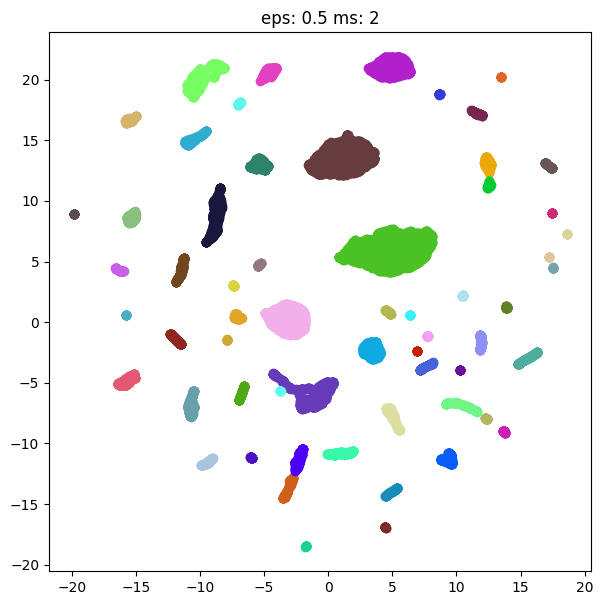

In [10]:
data_sampling, config_sampling = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_input, config_input.copy(), [sampling_args])

#### input data와 sampling 한 후 data shape 비교

In [11]:
data_input['dataframe'].shape

(10100, 36)

In [12]:
data_sampling['dataframe'].shape

(1100, 37)

In [13]:
data_sampling['dataframe']['label'].value_counts()

OK    1000
NG     100
Name: label, dtype: int64

<br>

#### 3. 그룹키 기준으로 데이터 subgroup 나누어 sampling 적용하기
- 그룹키 기준으로 subgroup을 생성하여 각 그룹 데이터에 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|sampling_groupkey_columns|그룹키로 지정할 컬럼을 입력합니다.(3개 까지 가능)|-|컬럼 명 입력|
|sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|sampling_num|sampling_num_type 인자를 입력합니다.|-|위 sampling 수 지정 참고|
- 아래는 그룹키 컬럼을 기준으로 입력한 데이터 수 만큼 random sampling을 진행하는 예제입니다.
- sampling_args['argument 명'] = '값'을 입력하여 sampling asset의 arguments를 입력합니다.

In [14]:
step = 1
sampling_args = alo.user_parameters[pipeline][step]['args'][0].copy()
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'random'
sampling_args['sampling_groupkey_columns'] = 'groupkey'
sampling_args['sampling_num_type'] = 'number'
sampling_args['sampling_num'] = 500

In [15]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'random',
 'label_sampling': False,
 'ignore_label_class': None,
 'negative_target_class': None,
 'label_sampling_num_type': None,
 'label_sampling_num': None,
 'sampling_groupkey_columns': 'groupkey',
 'sampling_num_type': 'number',
 'sampling_num': 500}

- sampling asset을 구동합니다

In [16]:
data_sampling, config_sampling = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_input, config_input.copy(), [sampling_args])

************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/project2023/TCR/231030/tcr/alo//.train_artifacts/models/sampling/
load configs 0.00035 sec
make groupkey dataframe 0.00791 sec
groupkey:('g2',), 500개 sampling 시작
groupkey:('g3',), 500개 sampling 시작
groupkey:('g1',), 500개 sampling 시작
sampling process done 0.00200 sec
sampling asset 종료


/home/jovyan/project2023/TCR/231030/tcr/alo/assets/sampling/asset_sampling.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


#### input data와 sampling 한 후 data shape 비교

In [17]:
data_input['dataframe'].shape

(10100, 36)

In [18]:
data_input['dataframe']['groupkey'].value_counts()

g3    3535
g2    3535
g1    3030
Name: groupkey, dtype: int64

In [19]:
data_sampling['dataframe'].shape

(1500, 37)

In [20]:
data_sampling['dataframe']['groupkey'].value_counts()

g3    500
g2    500
g1    500
Name: groupkey, dtype: int64

<br>

#### 4. 라벨과 그룹키 기준으로 데이터 subgroup 나누어 sampling 적용하기
- 라벨과 그룹키 기준으로 subgroup을 생성하여 각 그룹 데이터에 under sampling을 적용할 때 조정해야하는 arguments는 다음과 같습니다.  
|argument|설명|default 값|사용가능 값|
|:---:|:---:|:---:|:---:|
|sampling_type|sampling 유형을 선택합니다. |none(asset 사용x)|none, under, over(TBD)|
|sampling_method|under sampling 방법론을 선택합니다.|random|random, cluster, negative|
|label_sampling|label sampling 진행 여부를 선택합니다.|False(기능 사용x)|True, False|
|ignore_label_class|특정 클래스에 대해 샘플링하지 않을 경우 지정합니다.|-|클래스 명 입력|  
|label_sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|label_sampling_num|label_sampling_num_type의 인자를 입력합니다.|-|위 sampling 수 지정 참고|
|sampling_groupkey_columns|그룹키로 지정할 컬럼을 입력합니다.(3개 까지 가능)|-|컬럼 명 입력|
|sampling_num_type|샘플링 데이터 수 결정 방법을 지정합니다.|-|ratio,number,compare,mingroup|
|sampling_num|sampling_num_type 인자를 입력합니다.|-|위 sampling 수 지정 참고|
- 아래는 다음과 같은 룰이 적용된 random sampling 방법 예제입니다. 
    - NG 데이터는 샘플링 하지 않고 OK데이터는 NG데이터의 2배가 되도록 함
    - OK 데이터의 경우 입력한 그룹키 컬럼 별로 동일하게 샘플링을 진행함
- sampling_args['argument 명'] = '값'을 입력하여 sampling asset의 arguments를 입력합니다.

In [21]:
step = 1
sampling_args = alo.user_parameters[pipeline][step]['args'][0].copy()
sampling_args['sampling_type'] = 'under'
sampling_args['sampling_method'] = 'random'
sampling_args['label_sampling'] = True
sampling_args['ignore_label_class'] = 'NG'
sampling_args['label_sampling_num_type'] = 'compare'
sampling_args['label_sampling_num'] = {'NG':1,'OK':2}
sampling_args['sampling_groupkey_columns'] = 'groupkey'
sampling_args['sampling_num_type'] = 'mingroup'

In [22]:
sampling_args

{'sampling_type': 'under',
 'sampling_method': 'random',
 'label_sampling': True,
 'ignore_label_class': 'NG',
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {'NG': 1, 'OK': 2},
 'sampling_groupkey_columns': 'groupkey',
 'sampling_num_type': 'mingroup',
 'sampling_num': 0.8}

- sampling asset을 구동합니다

In [23]:
data_sampling, config_sampling = alo.process_asset_step(alo.asset_source[pipeline][step], step, pipeline, data_input, config_input.copy(), [sampling_args])

************************************************************
************************************************************
>> Successfully got model path for saving or loading your AI model: 
 /home/jovyan/project2023/TCR/231030/tcr/alo//.train_artifacts/models/sampling/
load configs 0.00054 sec
make groupkey dataframe 0.01902 sec
groupkey:('OK', 'g2'), 67개 sampling 시작
groupkey:('OK', 'g3'), 67개 sampling 시작
groupkey:('OK', 'g1'), 67개 sampling 시작
sampling process done 0.00156 sec
sampling asset 종료


/home/jovyan/project2023/TCR/231030/tcr/alo/assets/sampling/asset_sampling.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sampled'].loc[sampled_idx] = 1 # 'sampled' == 1일 때 sampling 된 것


#### input data와 sampling 한 후 data shape 비교

In [24]:
data_input['dataframe'].shape

(10100, 36)

In [25]:
data_input['dataframe'][['label','groupkey']].value_counts()

label  groupkey
OK     g2          3501
       g3          3500
       g1          2999
NG     g3            35
       g2            34
       g1            31
dtype: int64

In [26]:
data_sampling['dataframe'].shape

(301, 37)

In [27]:
data_sampling['dataframe'][['label','groupkey']].value_counts()

label  groupkey
OK     g2          67
       g1          67
       g3          67
NG     g3          35
       g2          34
       g1          31
dtype: int64